In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [5]:
import psycopg2
import pickle
import copy

In [6]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

### Mattilsynet 

In [7]:
try:
    cur = conn.cursor()
    df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer;", 
                                  conn)
except:
    conn.rollback()
    cur.close()

C:\Users\CL\AppData\Local\Temp\ipykernel_25480\2236806454.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \


In [8]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


# Ledere
Styremedlemer, Styreleder, Nestleder, Vara etc.

In [9]:
list_of_df = [  "df_styremedlemjunction_table",
                "df_varamedlemjunction_table",
                "df_styrets_lederjunction_table",
                "df_nestlederjunction_table",
                "df_kontaktpersonjunction_table",
                "df_innehaverjunction_table"]
daglig_leder = "df_daglig_lederjunction_table"
people = "df_people_gender"

In [10]:
def get_leader_info(name):
    path_ = "../Data/Extracted/"
    suffix = ".obj"

    with open(path_+name+suffix, 'rb') as f:
        df = pickle.load(f)
    return df

In [11]:
df_people = get_leader_info(people)
daglig_leder = get_leader_info(daglig_leder)

In [12]:
leaders = []

for item in list_of_df:
    leaders.append(get_leader_info(item))

In [14]:
# Gets all leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

for org_num in list_of_org_num:

    for leader_role in leaders:

        for index, row in leader_role.iterrows():

            if int(row['organisasjonsnummer']) == int(org_num):
                unique_leader[org_num].append(row['person_id'])

KeyboardInterrupt: 

In [ ]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [ ]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_leaders[key] = [len(value), np.nan]
    else:
        counted_leaders[key] = [len(value), sex/len(value)]

### Daglig leder

In [ ]:
# Gets all aglig leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

for org_num in list_of_org_num:

    for index, row in daglig_leder.iterrows():

        if int(row['organisasjonsnummer']) == int(org_num):
            unique_leader[org_num].append(row['person_id'])

In [ ]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [ ]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_daglig_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_daglig_leaders[key] = [len(value), np.nan]
    else:
        counted_daglig_leaders[key] = [len(value), sex/len(value)]

In [ ]:
print(len(counted_daglig_leaders))
print(len(counted_leaders))

##### Storing the data due to long processing time.

In [ ]:
leader_and_direct_leader_data = [counted_daglig_leaders, counted_leaders]

In [ ]:
# with open('leader_and_direct_leader_data.obj', 'wb') as fp:
# 	pickle.dump(leader_and_direct_leader_data, fp)

In [15]:
with open('leader_and_direct_leader_data.obj', 'rb') as f:
    leader_and_direct_leader_data = pickle.load(f)

### Styremedlemmer

In [16]:
try:
    cur = conn.cursor()
    df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN styremedlem_junction sj ON oj.orgnumber = sj.organisasjonsnummer \
                                  JOIN people p ON sj.person_id = p.person_id ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()


C:\Users\CL\AppData\Local\Temp\ipykernel_25480\2516288090.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \


### Google Review

In [17]:
try:
    cur = conn.cursor()
    df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \
                                 FROM google_review gr;", 
                                 conn)
except:
    conn.rollback()
    cur.close()


C:\Users\CL\AppData\Local\Temp\ipykernel_25480\2155275846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \


In [18]:
avg_df = df_sql_reviews.groupby('orgnummer').mean()
min_max_df = (df_sql_reviews.groupby('orgnummer').max()) - (df_sql_reviews.groupby('orgnummer').min())
min_max_df['dif_rating'] = min_max_df.pop('individual_rating')
avg_df['avg_rating'] = avg_df.pop('individual_rating')

In [19]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


# START HERE

In [160]:
df_test = pd.merge(df_sql_mat, avg_df, how='left', on='orgnummer')
df_test = pd.merge(df_test, min_max_df, how='left', on='orgnummer')

In [161]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.4,2.0
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.0,2.0
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.6,1.0
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.8,1.0
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.2,3.0
...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,NaN,NaN
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.4,4.0
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.0,0.0
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.6,4.0


In [162]:
df_test.isnull().sum()

overordnetenhet         0
orgnummer               0
postnr                  0
total_karakter          0
dato                    0
tilsynsbesoektype       0
antallansatte           0
naeringskode1_kode      0
avg_rating            658
dif_rating            658
dtype: int64

In [163]:
mean_avg = df_test['avg_rating'].mean()
mean_dif = df_test['dif_rating'].mean()
dt_test = df_test['avg_rating'].fillna(value=mean_avg, inplace=True)
dt_test = df_test['dif_rating'].fillna(value=mean_dif, inplace=True)

#### Adding cordinate location.

In [164]:
try:
    cur = conn.cursor()
    df_cordinates = pd.read_sql_query(""" 
            SELECT m.orgnummer, a.latitude, a.longitude
            FROM address a
            JOIN mattilsynet m on a.name = m.adresse;
            """
                            ,conn)
except:
    conn.rollback()
    cur.close()

C:\Users\CL\AppData\Local\Temp\ipykernel_25480\3758981977.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cordinates = pd.read_sql_query("""


In [165]:
df_cordinates = df_cordinates.drop_duplicates(subset=['orgnummer'])

In [166]:
# Merging the df's
df_test = df_test.merge(df_cordinates, how='left', on='orgnummer')

In [167]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260
...,...,...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041


In [168]:
df_test.columns

Index(['overordnetenhet', 'orgnummer', 'postnr', 'total_karakter', 'dato',
       'tilsynsbesoektype', 'antallansatte', 'naeringskode1_kode',
       'avg_rating', 'dif_rating', 'latitude', 'longitude'],
      dtype='object')

#### Adding in the leader and direct leader data.

In [169]:
df_test['direct_leader'] = np.nan
df_test['direct_leader_sex'] = np.nan
df_test['leaders'] = np.nan
df_test['leaders_sex'] = np.nan

In [170]:
def add_data_to_df(o_org, gender = False, direct = True):
    index = 0
    if gender == False:
        index = 0
    else:
        index = 1
    
    if direct == True:
        data = leader_and_direct_leader_data[0]
    else:
        data = leader_and_direct_leader_data[1]

    return data[o_org][index]

In [171]:
df_test['direct_leader'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = True))
df_test['direct_leader_sex'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = True))
df_test['leaders'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = False))
df_test['leaders_sex'] = df_test['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = False))

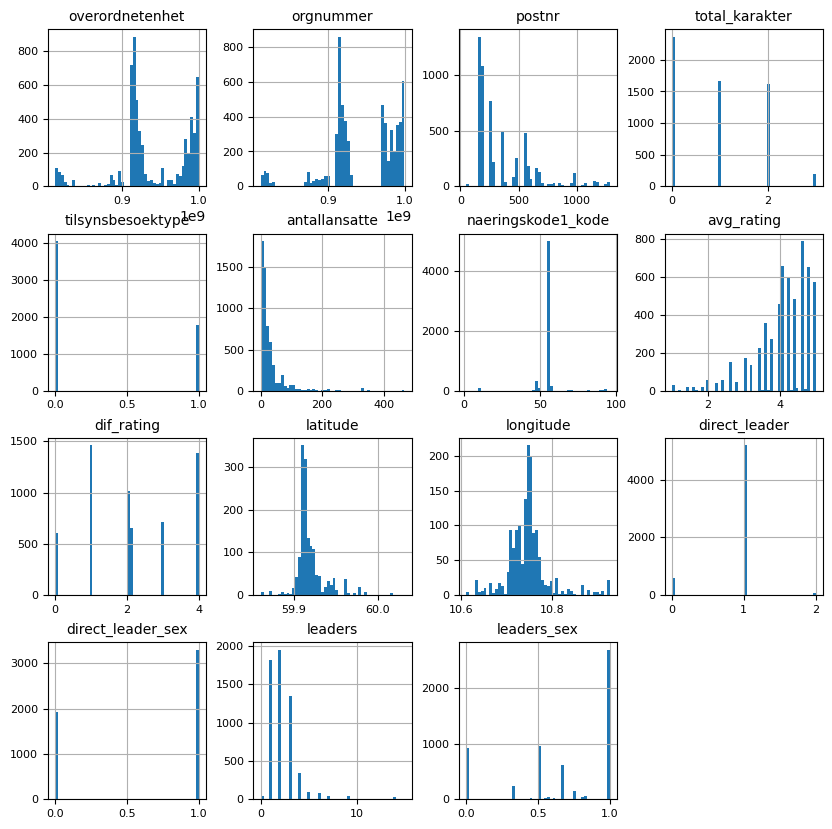

In [172]:
fig = df_test.hist(figsize=[10,10], bins=50, xlabelsize=8, ylabelsize=8)
[x.title.set_size(10) for x in fig.ravel()];
plt.show()

# DATA PREP

In [173]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_test['dato']
year_list = []

for i in dato.values:
    year_list.append(int(i[-4:]))

df_test['year'] = year_list

In [174]:
del df_test['overordnetenhet']
df_test

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude,direct_leader,direct_leader_sex,leaders,leaders_sex,year
0,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN,1,1.0,3,1.000000,2022
1,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN,1,1.0,3,1.000000,2020
2,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419,1,0.0,5,0.600000,2017
3,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924,0,NaN,2,0.500000,2018
4,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260,1,1.0,9,0.555556,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338,1,1.0,1,1.000000,2023
5837,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009,1,0.0,1,1.000000,2022
5838,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN,1,1.0,2,0.500000,2022
5839,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041,1,1.0,2,1.000000,2022


In [175]:
# Adding monthly data
month = df_test['dato']
month_list = []

for i in dato.values:
    month_list.append(int(i[2:-4:]))

df_test['month'] = month_list

#### Adding a binary pass fail score

In [176]:
df_test["pass"] = 0

def adding_binary_score(total_grade):
    if total_grade < 2:
        return 1
    else:
        return 0

df_test['pass'] = df_test['total_karakter'].map(adding_binary_score)

# Adding in num of last fail

In [178]:
df_test['date'] = pd.to_datetime(df_test['dato'], format='%d%m%Y')

In [183]:
df_test['num_fail'] = 0
df_test = df_test.sort_values('date')
org_num = df_test['orgnummer'].tolist()

In [184]:
org_num_dict = {}
for num in org_num:
    org_num_dict[num] = 0

# TRAIN TEST SPLIT
Splitting by date and not randomly

In [143]:
df_før_2023 = df_test[df_test['year'] < 2023]
df_etter_2023 = df_test[df_test['year'] == 2023]

In [144]:
df_2023 = df_test[df_test['year'] == 2023]
df_2022_fall = df_test[df_test['year'] == 2022]
df_2022_fall = df_2022_fall[df_test['month'] > 6]
df_val = pd.concat([df_2023, df_2022_fall])

C:\Users\CL\AppData\Local\Temp\ipykernel_25480\865517078.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2022_fall = df_2022_fall[df_test['month'] > 6]


In [145]:
df_sub_2022 = df_test[df_test['year'] < 2022]
df_2022_spring = df_test[df_test['year'] == 2022]
df_2022_spring = df_2022_spring[df_test['month'] <= 6]
df_train = pd.concat([df_sub_2022, df_2022_spring])

C:\Users\CL\AppData\Local\Temp\ipykernel_25480\1103686767.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2022_spring = df_2022_spring[df_test['month'] <= 6]


In [146]:
print(len(df_val)+len(df_train))
print(len(df_test))

5841
5841


In [147]:
df_test = df_val

In [148]:
feature_list = ['orgnummer', 'postnr', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month']

In [111]:
# df_før_2023
# df_etter_2023

features_train = df_før_2023[feature_list]
features_test = df_etter_2023[feature_list]
X_train = np.c_[features_train]
y_train = np.c_[df_før_2023['total_karakter']]
y_c_train = np.c_[df_før_2023['pass']]
X_test = np.c_[features_test]
y_test = np.c_[df_etter_2023['total_karakter']]
y_c_test = np.c_[df_etter_2023['pass']]

In [149]:
features_train = df_train[feature_list]
features_test = df_test[feature_list]
X_train = np.c_[features_train]
y_train = np.c_[df_train['total_karakter']]
y_c_train = np.c_[df_train['pass']]
X_test = np.c_[features_test]
y_test = np.c_[df_test['total_karakter']]
y_c_test = np.c_[df_test['pass']]

In [150]:
y_test = y_c_test
y_train = y_c_train

In [151]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4866
X_test len : 975
y_train len : 4866
y_test len : 975


In [152]:
print(X_train.shape, y_train.shape)

(4866, 15) (4866, 1)


# Naiv score

In [153]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}') # 1169

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9147

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7819

y_pred_naiv : 975
Naiv MSE : 0.44568961973783067
Naiv MAE : 0.4157848809636725


In [154]:
df_train

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude,direct_leader,direct_leader_sex,leaders,leaders_sex,year,month,pass
1,974999439,366,0,23012020,0,17.0,47.241,4.0,2.0,NaN,NaN,1,1.0,3,1.000000,2020,1,1
2,915893848,369,0,14092017,1,25.0,56.101,4.6,1.0,59.930309,10.715419,1,0.0,5,0.600000,2017,9,1
3,919228660,178,0,21082018,1,7.0,56.101,4.8,1.0,59.922427,10.751924,0,NaN,2,0.500000,2018,8,1
4,912240770,1081,0,26112018,1,80.0,55.101,3.2,3.0,59.930122,10.868260,1,1.0,9,0.555556,2018,11,1
5,971761539,461,1,27042016,0,32.0,56.101,4.4,3.0,NaN,NaN,1,1.0,2,0.500000,2016,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,913205243,485,1,12052022,0,29.0,56.101,4.0,4.0,NaN,NaN,0,NaN,2,1.000000,2022,5,1
5821,914800099,154,1,10032022,0,31.0,56.101,3.8,4.0,59.910871,10.750735,1,0.0,1,0.000000,2022,3,1
5824,973116061,158,1,03052022,0,65.0,56.101,4.6,1.0,NaN,NaN,1,1.0,2,1.000000,2022,5,1
5825,981612035,668,1,04052022,0,0.0,47.241,4.4,2.0,NaN,NaN,1,0.0,4,0.500000,2022,5,1


In [155]:
df_test.groupby('pass').count()

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude,direct_leader,direct_leader_sex,leaders,leaders_sex,year,month
pass,,,,,,,,,,,,,,,,,
0,261,261,261,261,261,261,261,261,261,82,82,261,237,261,261,261,261
1,714,714,714,714,714,714,714,714,714,261,261,714,636,714,710,714,714


In [156]:
print(261+714)

975


# XGBoost Model

In [157]:
classifier = xgb.XGBClassifier(early_stopping_rounds = 100, max_depth = 10)
classifier.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(classifier.feature_importances_.reshape(1,-1), columns = [feature_list])

[0]	validation_0-logloss:0.63089
[1]	validation_0-logloss:0.60353
[2]	validation_0-logloss:0.58776
[3]	validation_0-logloss:0.57942
[4]	validation_0-logloss:0.57843
[5]	validation_0-logloss:0.57449
[6]	validation_0-logloss:0.57530
[7]	validation_0-logloss:0.58107
[8]	validation_0-logloss:0.58267
[9]	validation_0-logloss:0.59099
[10]	validation_0-logloss:0.59295
[11]	validation_0-logloss:0.60003
[12]	validation_0-logloss:0.60379
[13]	validation_0-logloss:0.60550
[14]	validation_0-logloss:0.60500
[15]	validation_0-logloss:0.60687
[16]	validation_0-logloss:0.60843
[17]	validation_0-logloss:0.60853
[18]	validation_0-logloss:0.61005
[19]	validation_0-logloss:0.61175
[20]	validation_0-logloss:0.61307
[21]	validation_0-logloss:0.61523
[22]	validation_0-logloss:0.62500
[23]	validation_0-logloss:0.62737
[24]	validation_0-logloss:0.63158
[25]	validation_0-logloss:0.63408
[26]	validation_0-logloss:0.63703
[27]	validation_0-logloss:0.64176
[28]	validation_0-logloss:0.64420
[29]	validation_0-loglos

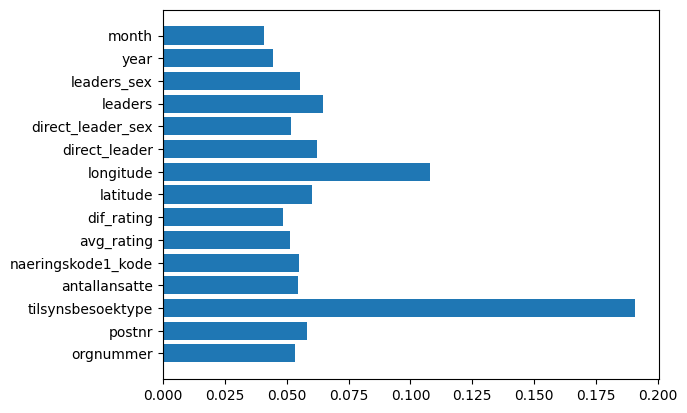

In [158]:
plt.barh(feature_list, classifier.feature_importances_)
plt.show()

In [159]:
y_test_pred = classifier.predict(X_test)

In [122]:
y_test_pred

count = 0
for pred, actual in zip(y_test_pred, y_test):
    if pred != actual:
        count += 1
print(count)
print(len(y_test_pred))

print((len(y_test_pred)-count)/len(y_test_pred) * 100)

38
132
71.21212121212122


In [123]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 100,
    max_depth = 10
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [feature_list])


[0]	validation_0-rmse:0.47271
[1]	validation_0-rmse:0.46240
[2]	validation_0-rmse:0.45332
[3]	validation_0-rmse:0.44515
[4]	validation_0-rmse:0.44315
[5]	validation_0-rmse:0.44342
[6]	validation_0-rmse:0.44295
[7]	validation_0-rmse:0.44142
[8]	validation_0-rmse:0.44098
[9]	validation_0-rmse:0.44706
[10]	validation_0-rmse:0.44630
[11]	validation_0-rmse:0.44799
[12]	validation_0-rmse:0.45144
[13]	validation_0-rmse:0.45315
[14]	validation_0-rmse:0.45404
[15]	validation_0-rmse:0.45542
[16]	validation_0-rmse:0.45545
[17]	validation_0-rmse:0.45471
[18]	validation_0-rmse:0.45754
[19]	validation_0-rmse:0.46172
[20]	validation_0-rmse:0.46280
[21]	validation_0-rmse:0.46339
[22]	validation_0-rmse:0.46118
[23]	validation_0-rmse:0.46182
[24]	validation_0-rmse:0.46008
[25]	validation_0-rmse:0.45978
[26]	validation_0-rmse:0.46072
[27]	validation_0-rmse:0.46245
[28]	validation_0-rmse:0.46448
[29]	validation_0-rmse:0.46464
[30]	validation_0-rmse:0.46554
[31]	validation_0-rmse:0.46560
[32]	validation_0-

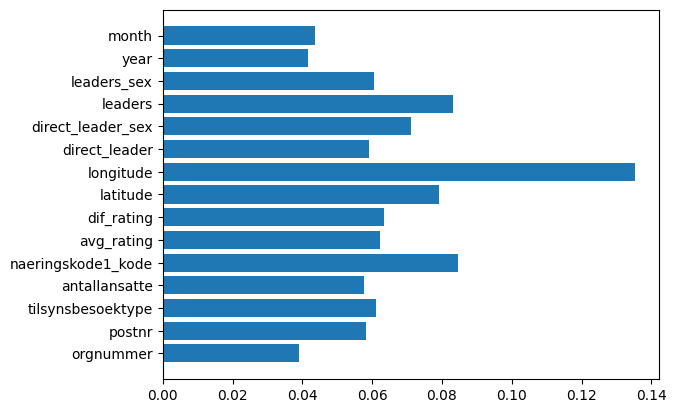

In [124]:
plt.barh(feature_list, regressor.feature_importances_)
plt.show()

# Scoring xg

In [125]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {r2_test_xg}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {np.sqrt(mse_test_xg)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Train MAE XG : {mae_test_xg}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.5956363610437291
Train MSE XG : 0.2941985793662625
Train MAE XG : 0.23947142184351308
Test R2 XG : 0.07927214591089904
Test MSE XG : 0.4409766754829694
Train MAE XG : 0.35900187571391917


# Decrepit







# Linear Regression Model

In [ ]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {r2_test}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {mae_test}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {np.sqrt(mse_test)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

# Logistic Regression Model

In [ ]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[1,1]
fn_train = cm_train[2,2]
tp_train = cm_train[3,3]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

# KNeighbors Regressor Model

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors=15)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSEtest : {np.sqrt(mse_test_knn)}') # 0.8453